In [13]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
from fastai.callbacks.tracker import SaveModelCallback
import fastai

In [2]:
import utils

In [3]:
from my_nn_modules import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [4]:
# Load data
#train = pd.read_pickle(BIN + 'processed_data/aod/scaled_all_jets_partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/scaled_all_jets_partial_test.pkl')

train = pd.read_pickle(BIN + 'processed_data/aod/scaled_all_jets_partial_train_10percent.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/scaled_all_jets_partial_test_10percent.pkl')

#train = train.sample(frac=0.1).reset_index(drop=True)  # Pick out a fraction of the data
#test = test.sample(frac=0.1).reset_index(drop=True)

n_features = len(train.loc[0])

train

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,0.757521,-0.140825,0.678256,0.443671,-0.670868,-0.143641,-0.594394,0.677183,-0.616398,-0.529598,...,0.728694,0.498170,0.937532,0.766256,-0.383182,-0.414652,-0.945960,0.429406,-0.314889,-0.455179
1,0.224783,-0.182344,-0.852832,0.220336,-0.286877,-0.186034,-0.162913,-0.853924,-0.058284,0.475935,...,0.585626,0.330726,0.343927,0.895340,-0.107903,-0.643980,-0.945960,0.954136,0.853435,0.849455
2,-0.177786,0.658116,0.514012,-0.032665,0.679313,0.660752,0.724703,0.517978,0.734236,0.035457,...,-0.834178,-0.717147,-0.926623,-0.222981,-0.383182,-0.800009,-0.945960,0.711061,0.563813,0.370576
3,-0.681642,-0.053673,-0.826917,-0.166576,-0.847386,-0.059109,-0.778948,-0.846808,-0.817478,-0.019042,...,-0.859520,-0.050592,-0.229659,-0.123791,0.441872,0.453160,-0.945960,0.607746,0.320743,0.253810
4,0.634675,-0.919637,-0.733460,0.926913,0.279324,-0.920371,0.501128,-0.733044,0.455556,0.824624,...,0.514492,0.714765,0.518257,0.339026,-0.615023,-0.530897,0.872233,-0.640697,-0.998902,-0.998902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955655,-0.808197,-0.154881,-0.186506,-0.506143,0.679313,-0.155204,0.706122,-0.187702,0.749062,0.239473,...,-0.257041,-0.827160,-0.737320,-0.210174,-0.107903,0.971596,-0.945960,0.804543,0.780237,0.698404
955656,0.369740,-0.750477,0.767564,0.370356,-0.940900,-0.754746,-0.925489,0.795179,-0.927073,-0.004318,...,0.366177,-0.013286,-0.134997,0.537806,0.179709,-0.279317,0.734433,0.611631,-0.998902,-0.344386
955657,0.950815,-0.359581,-0.350405,0.955640,0.513547,-0.360011,0.631163,-0.345810,0.589525,-0.088438,...,0.084371,0.656901,-0.604070,-0.398580,0.649661,0.322811,-0.945960,0.658806,-0.024681,0.091919
955658,-0.267686,0.911668,-0.862688,-0.480704,-0.004548,0.912780,0.086146,-0.854579,0.101448,-0.172433,...,-0.296498,-0.200536,-0.994623,-0.453281,-0.615023,-0.502369,0.862761,-0.206954,-0.998902,-0.998902


In [5]:
bs = 2048
# Create TensorDatasets
train_ds = TensorDataset(torch.tensor(train.values, dtype=torch.float), torch.tensor(train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test.values, dtype=torch.float), torch.tensor(test.values, dtype=torch.float))
# Create DataLoaders
train_dl, valid_dl = utils.get_data(train_ds, valid_ds, bs=bs)
# Return DataBunch
db = basic_data.DataBunch(train_dl, valid_dl)

In [6]:
n_inputs = len(train.columns)
n_inputs

27

In [15]:
latent_dim = 18
nodes = [n_inputs, 200, 200, 200, latent_dim, 200, 200, 200, n_inputs]
model = AE_bn_LeakyReLU(nodes=nodes, no_last_bias=False)
model.train()

AE_bn_LeakyReLU(
  (encoder): Sequential(
    (0): Linear(in_features=27, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=18, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=Tru

In [16]:
loss_func = nn.MSELoss()

In [17]:
wd = 1e-1
from fastai.callbacks import ActivationStats
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, true_wd=True)

In [18]:
from fastai import train as tr
tr.lr_find(learn, stop_div=True, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


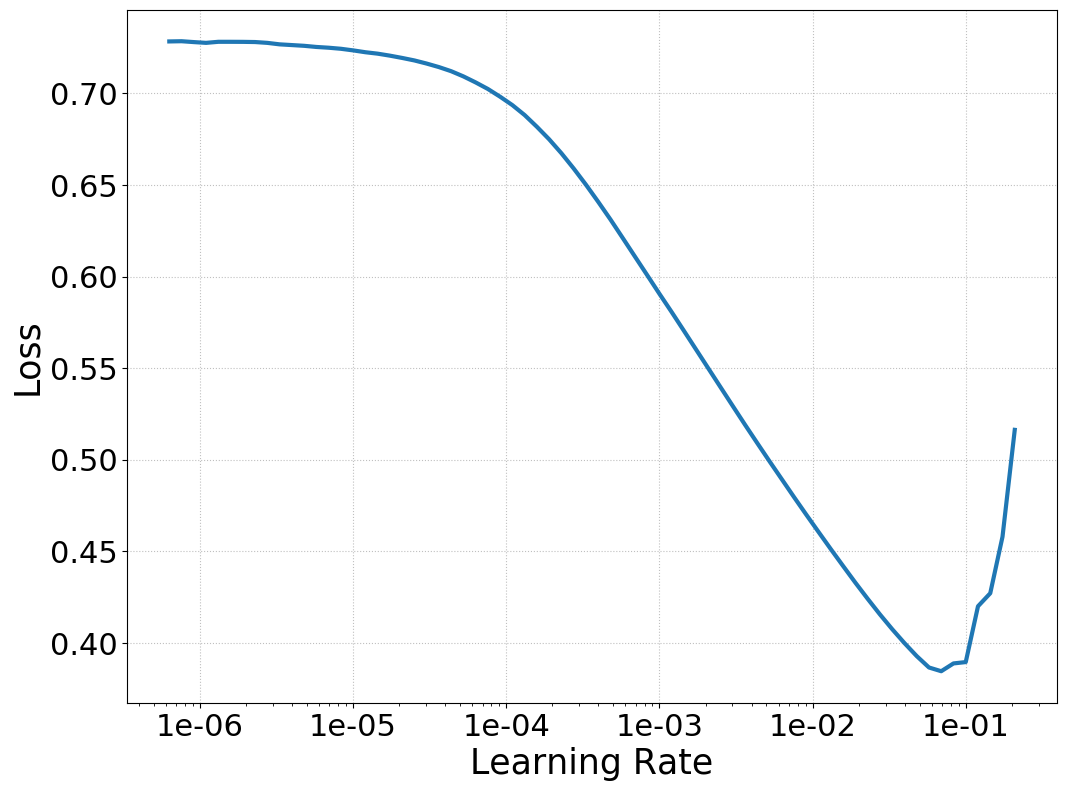

In [19]:
learn.recorder.plot()

In [20]:
lr = 1e-2
learn.fit_one_cycle(200, max_lr=lr, wd=wd, callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='best_bs%s_lr%s_wd%s' % (bs, lr, wd))])

epoch,train_loss,valid_loss,time
0,0.024648,0.021545,02:38
1,0.011272,0.010312,02:44
2,0.007369,0.006671,02:41
3,0.005692,0.005811,03:12
4,0.004409,0.004035,03:16
5,0.003939,0.004140,02:45
6,0.003670,0.003583,02:37
7,0.003329,0.003636,02:37
8,0.003111,0.003206,02:39
9,0.002975,0.003187,02:39


Better model found at epoch 0 with valid_loss value: 0.02154545858502388.
Better model found at epoch 1 with valid_loss value: 0.01031166035681963.
Better model found at epoch 2 with valid_loss value: 0.006670833565294743.
Better model found at epoch 3 with valid_loss value: 0.005811221897602081.
Better model found at epoch 4 with valid_loss value: 0.004034715238958597.
Better model found at epoch 6 with valid_loss value: 0.003582602133974433.
Better model found at epoch 8 with valid_loss value: 0.0032062355894595385.
Better model found at epoch 9 with valid_loss value: 0.0031866971403360367.
Better model found at epoch 10 with valid_loss value: 0.0028223979752510786.
Better model found at epoch 11 with valid_loss value: 0.002809707308188081.
Better model found at epoch 12 with valid_loss value: 0.002476869849488139.
Better model found at epoch 18 with valid_loss value: 0.0019029424292966723.
Better model found at epoch 22 with valid_loss value: 0.0017236282583326101.


KeyboardInterrupt: 

In [28]:
lr = 1e-4
learn.fit_one_cycle(10, max_lr=lr, wd=wd, callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='best_bs%s_lr%s_wd%s' % (bs, lr, wd))])

epoch,train_loss,valid_loss,time
0,0.000889,0.000586,03:00
1,0.000903,0.000582,03:13
2,0.000885,0.000574,03:28
3,0.000879,0.000564,03:29
4,0.000868,0.000550,03:14
5,0.000861,0.000541,03:16
6,0.000851,0.000536,03:13
7,0.000831,0.000537,03:16
8,0.000824,0.000528,03:06
9,0.000832,0.000539,02:25


Better model found at epoch 0 with valid_loss value: 0.0005861691897735.
Better model found at epoch 1 with valid_loss value: 0.0005818710196763277.
Better model found at epoch 2 with valid_loss value: 0.0005742029752582312.
Better model found at epoch 3 with valid_loss value: 0.0005636466667056084.
Better model found at epoch 4 with valid_loss value: 0.0005500934203155339.
Better model found at epoch 5 with valid_loss value: 0.0005405702977441251.
Better model found at epoch 6 with valid_loss value: 0.0005362194497138262.
Better model found at epoch 8 with valid_loss value: 0.0005281851044856012.


In [ ]:
ls models

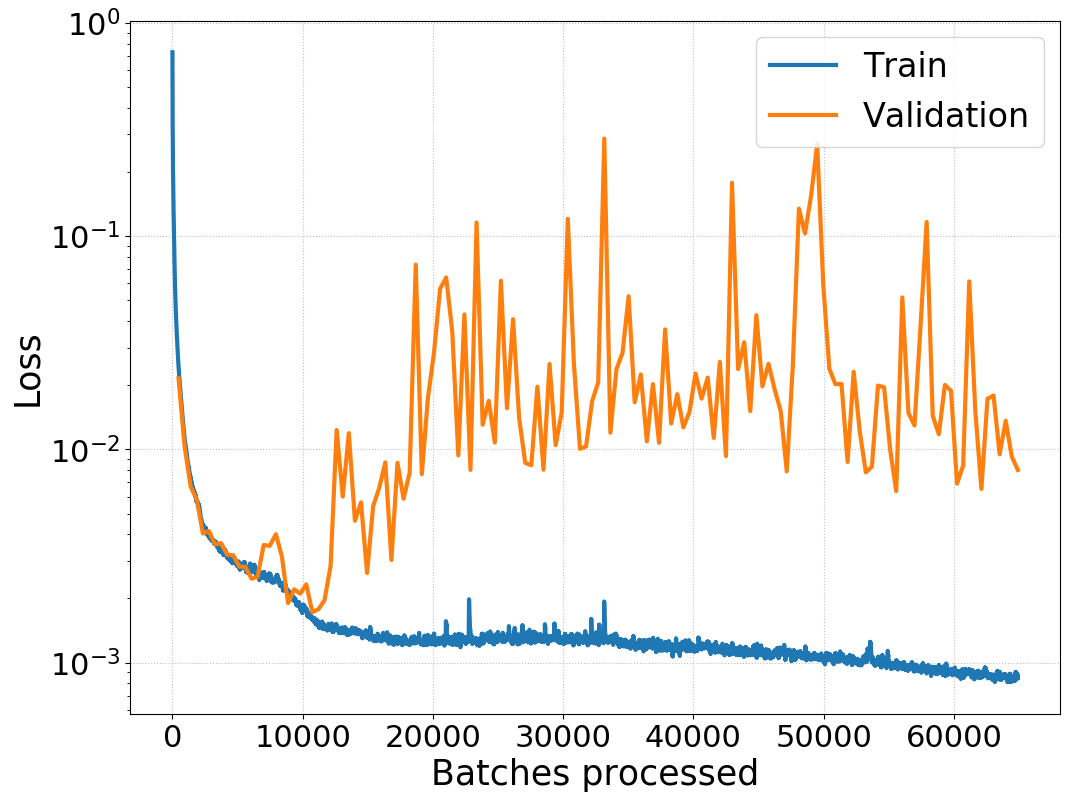

In [21]:
learn.recorder.plot_losses()
plt.yscale('log')

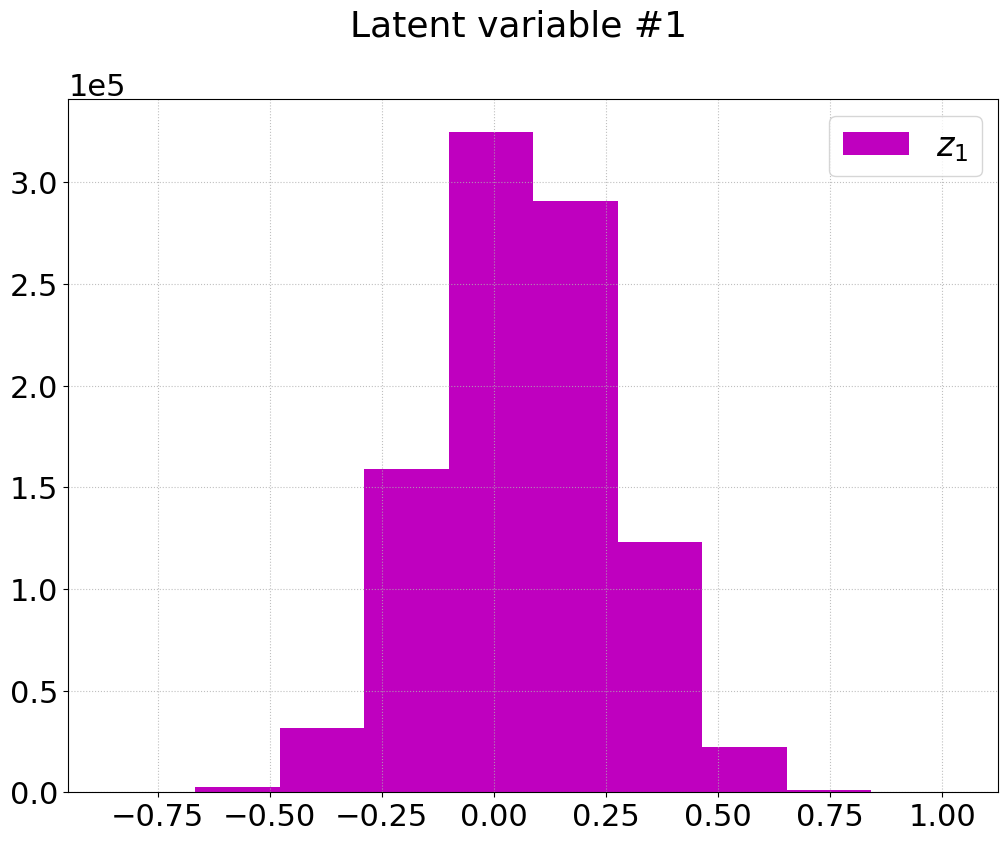

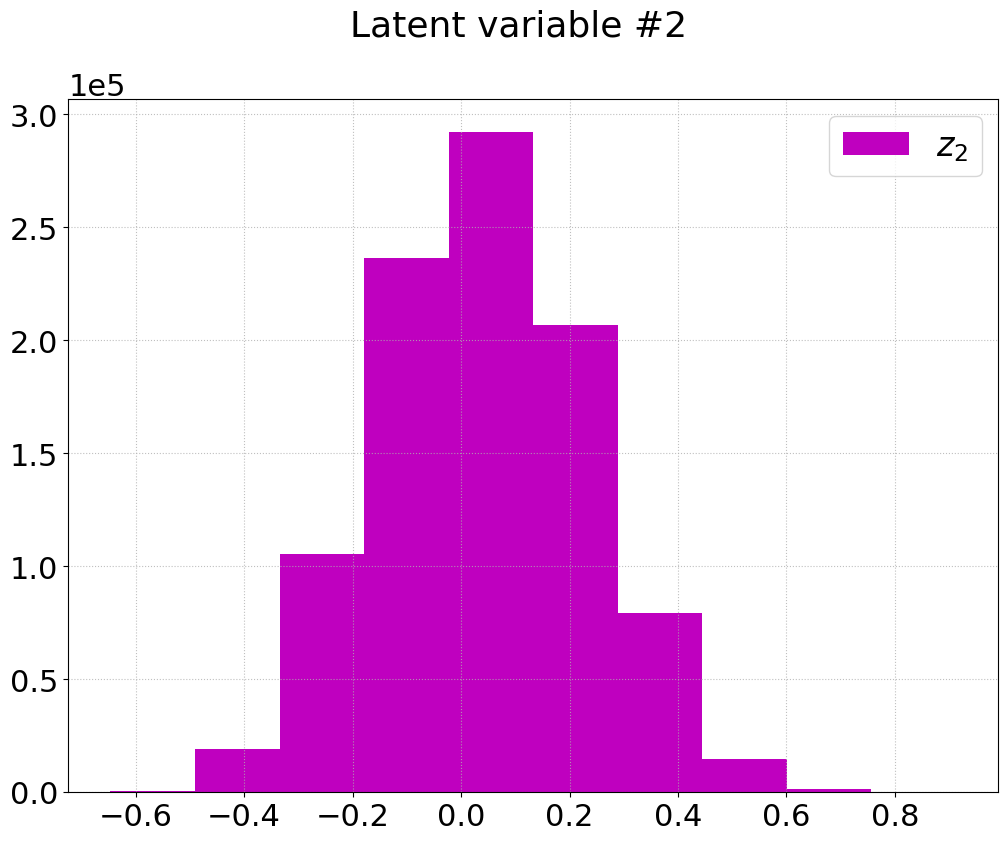

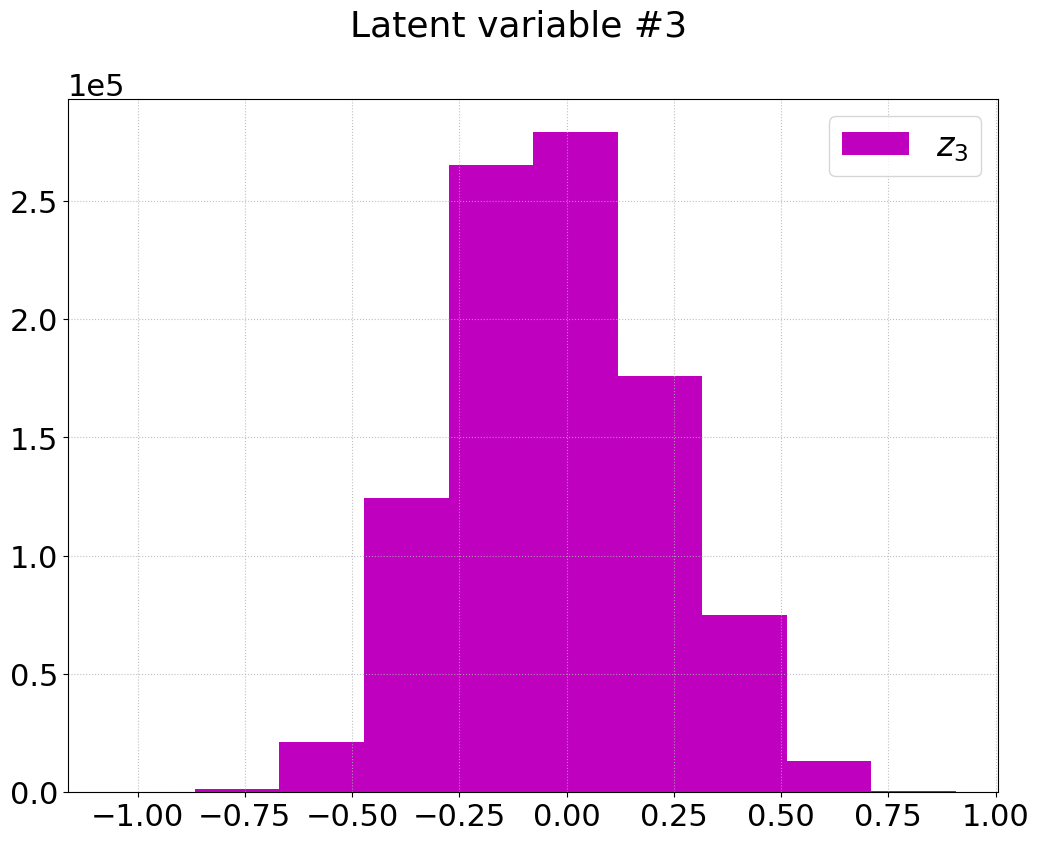

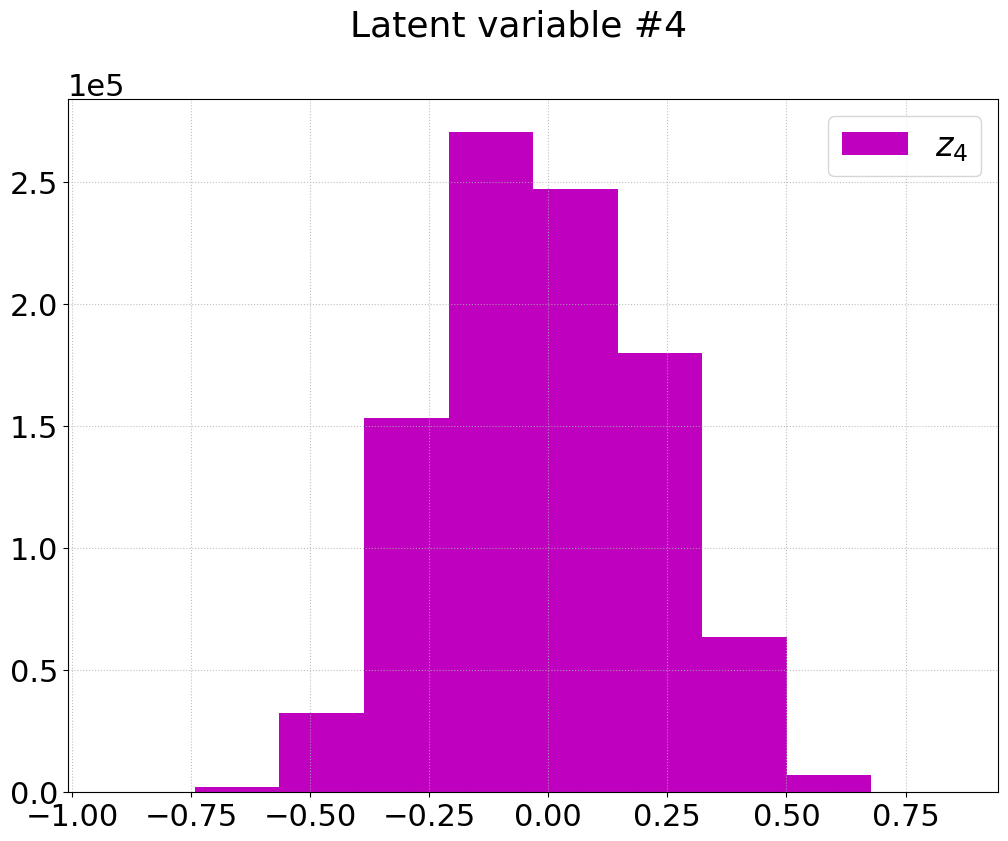

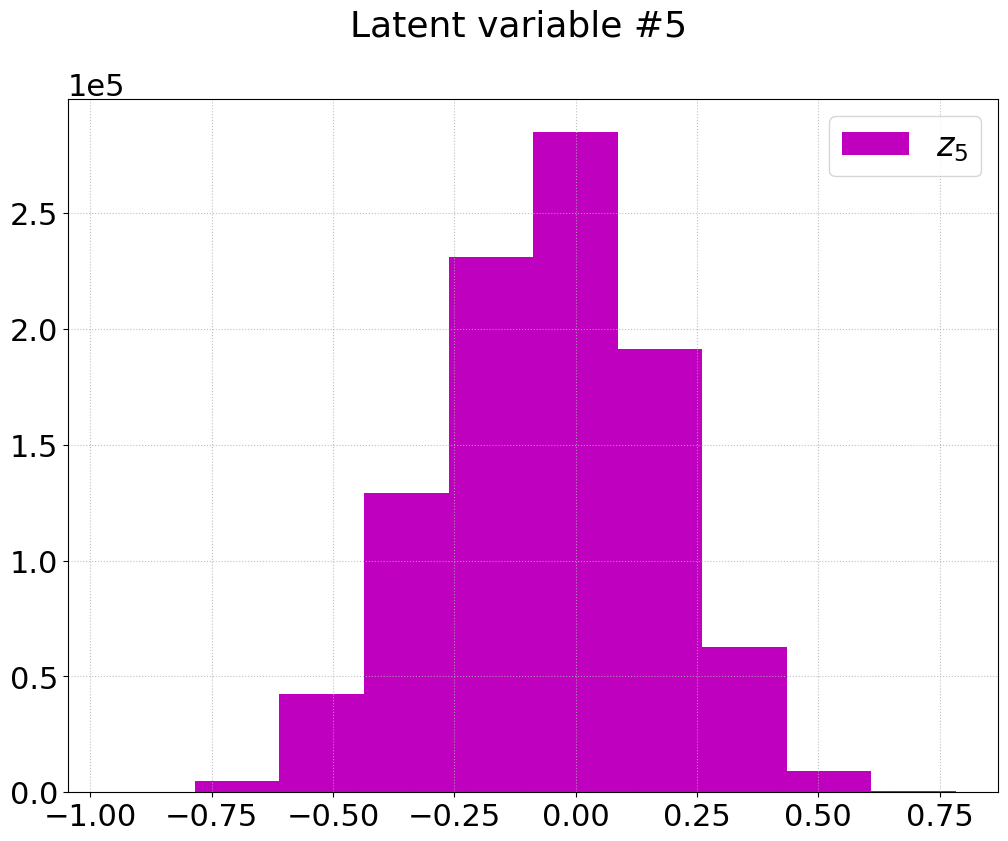

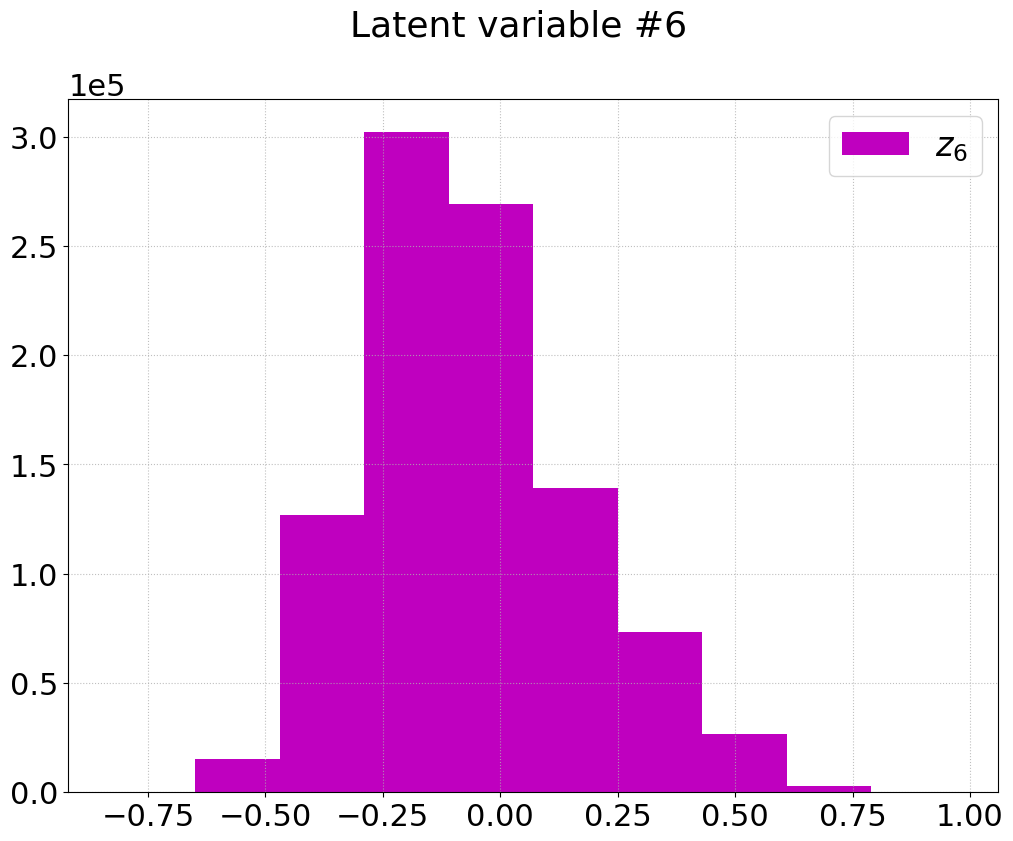

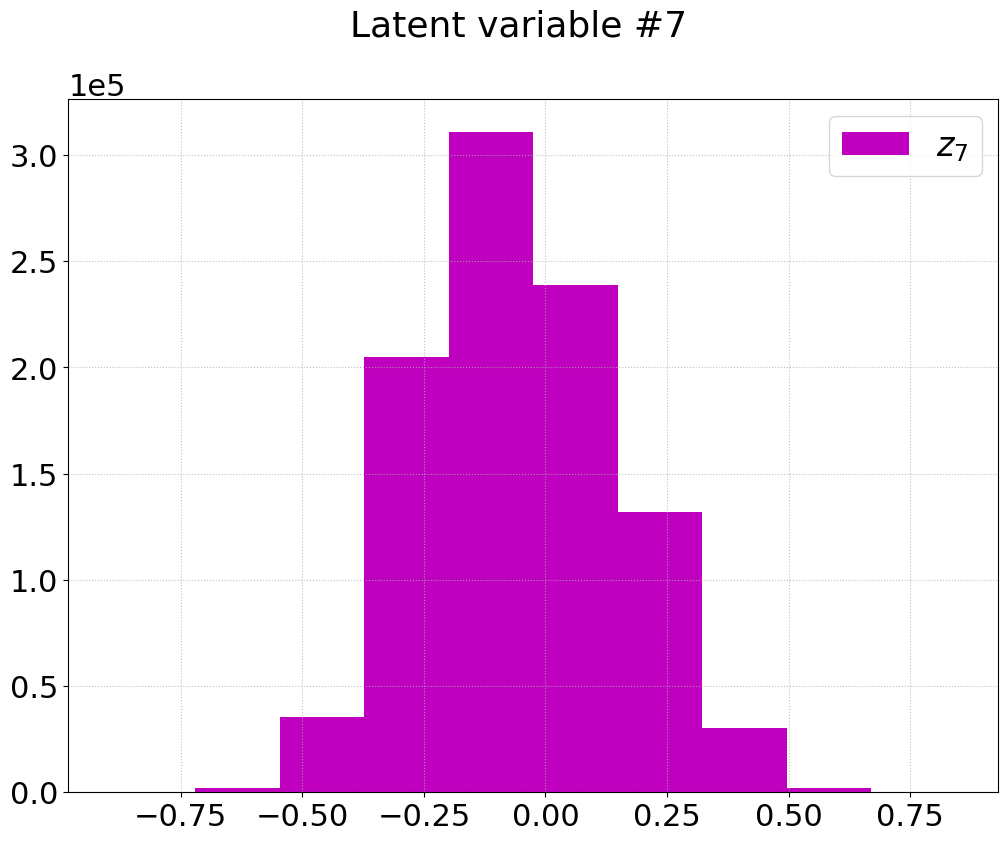

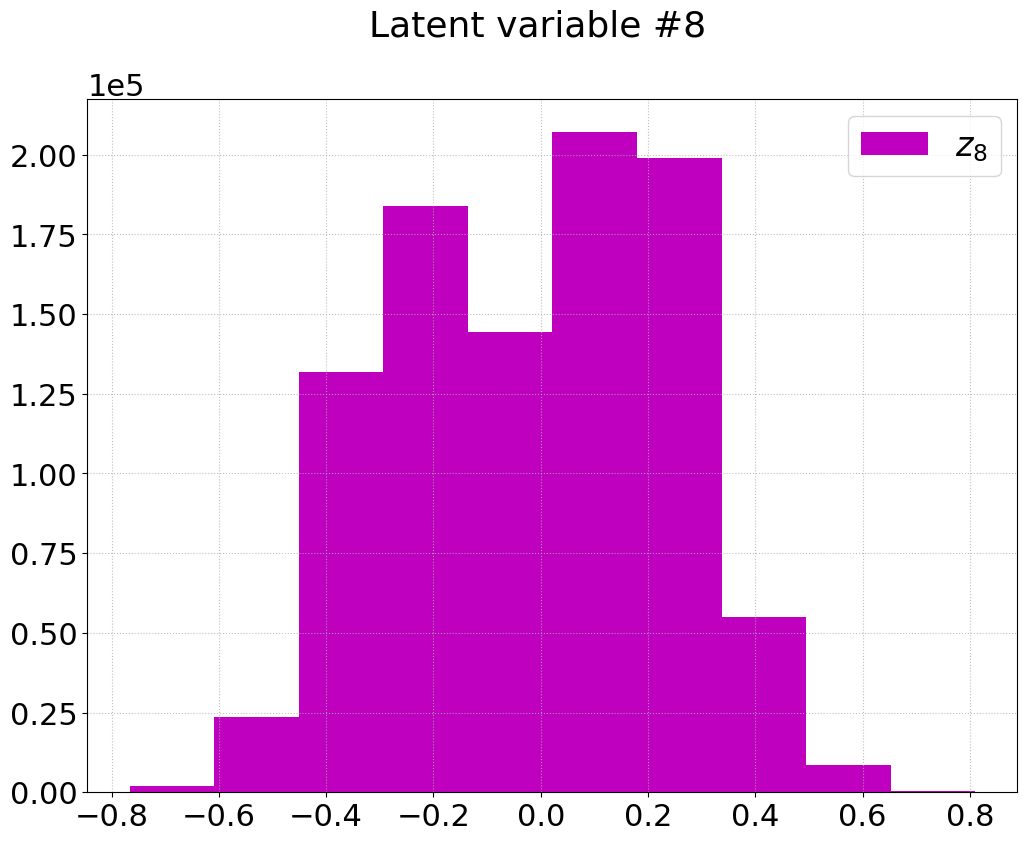

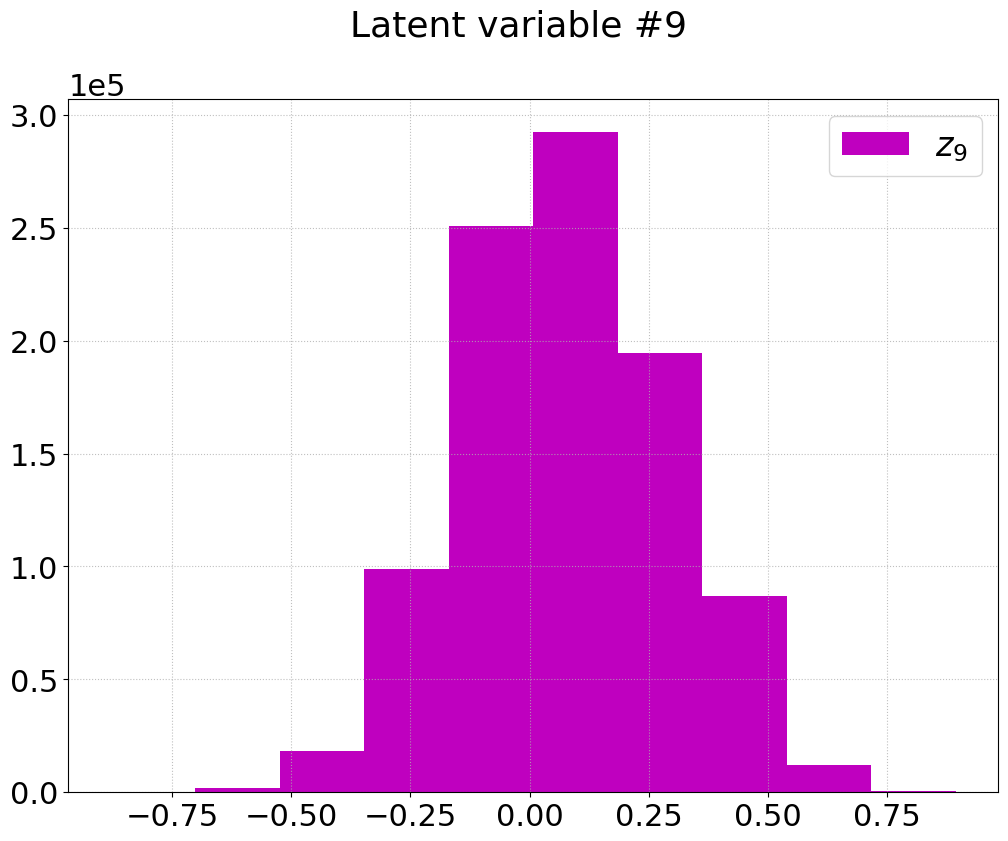

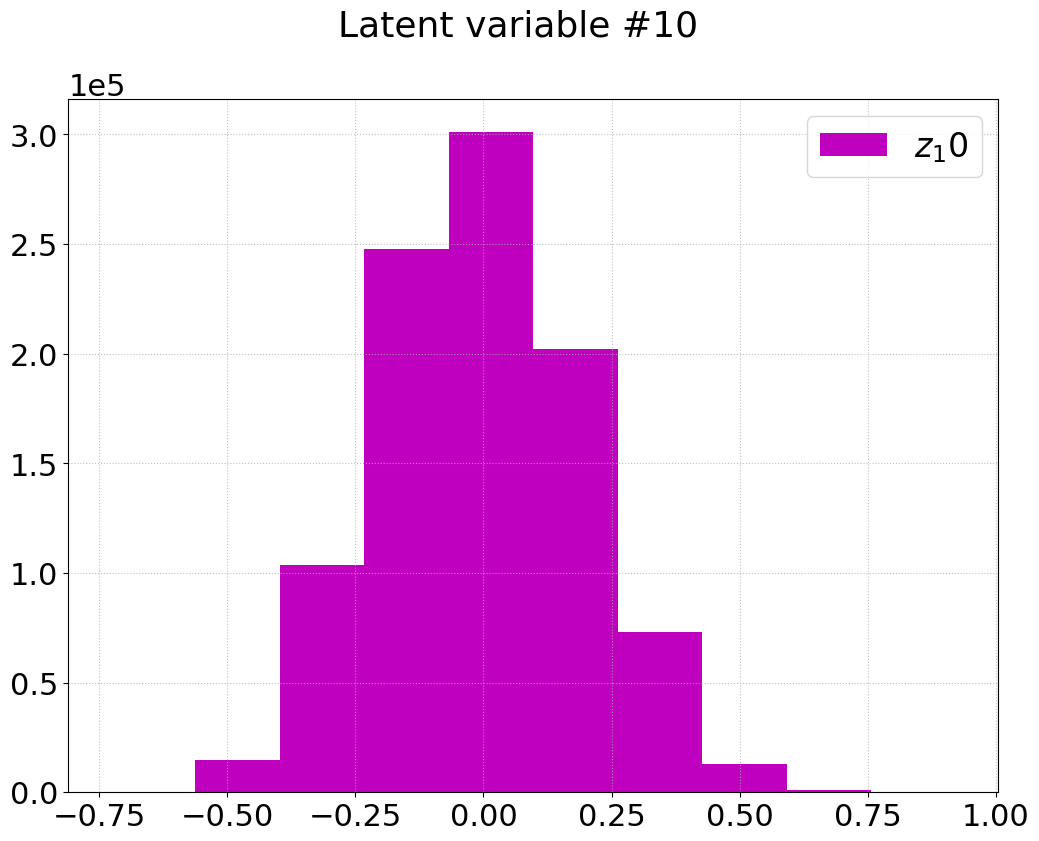

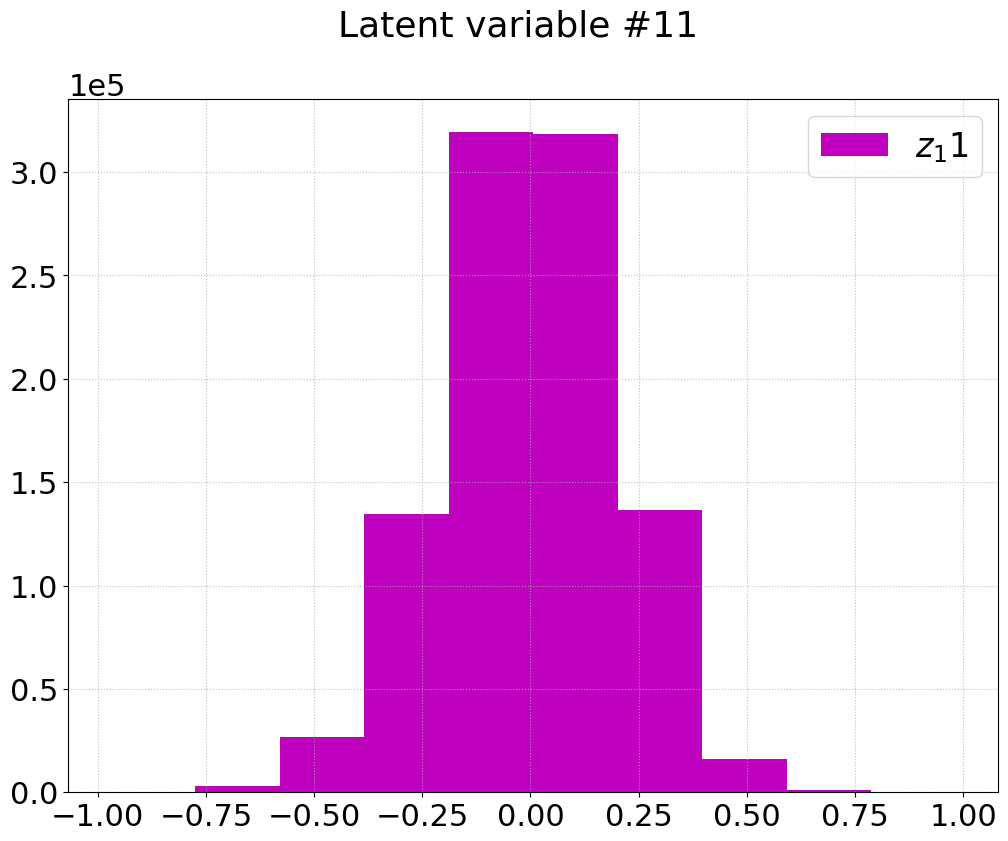

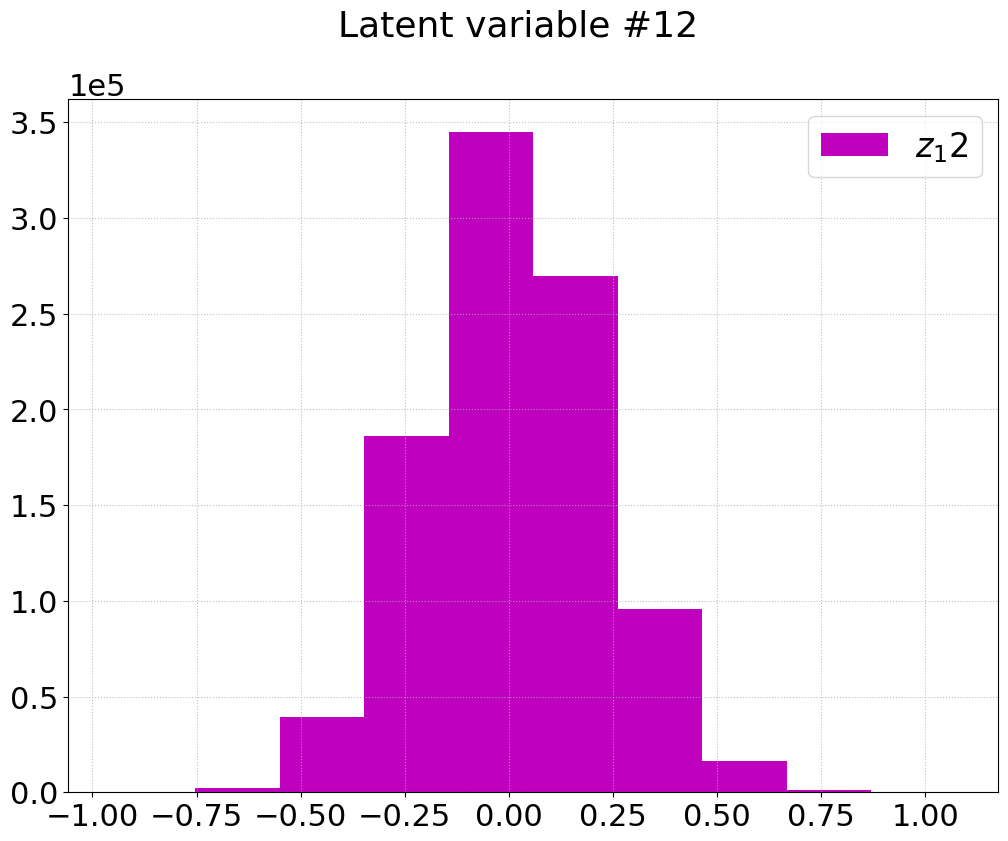

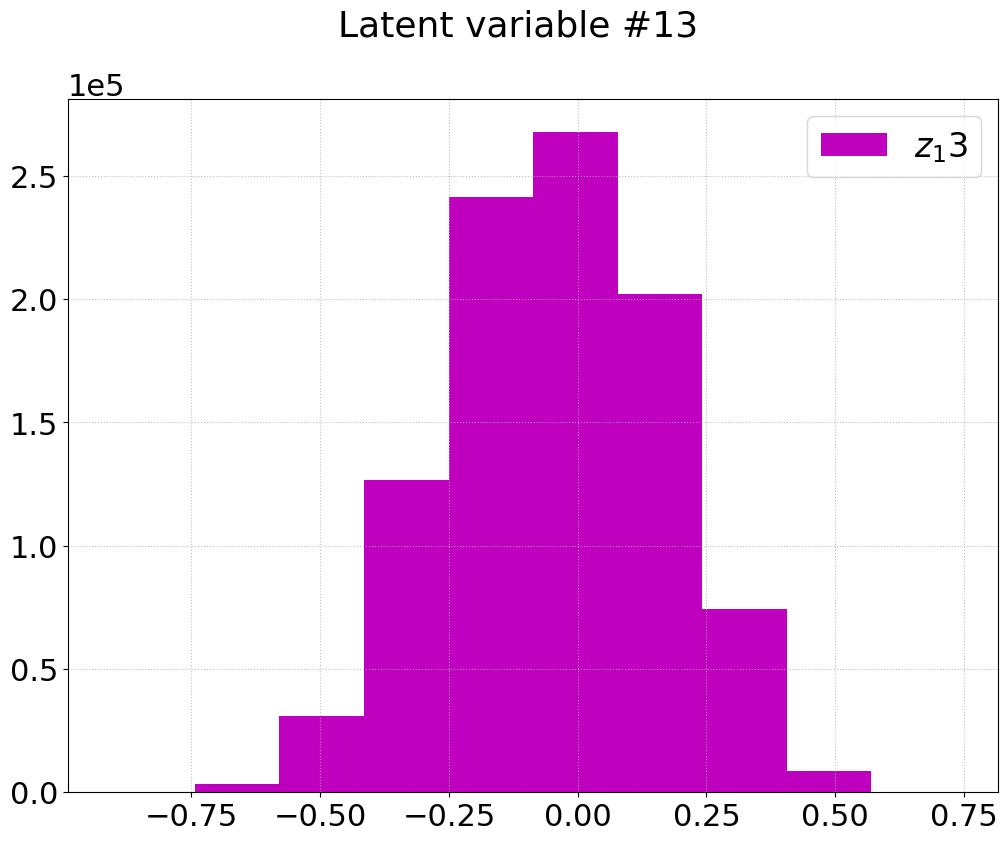

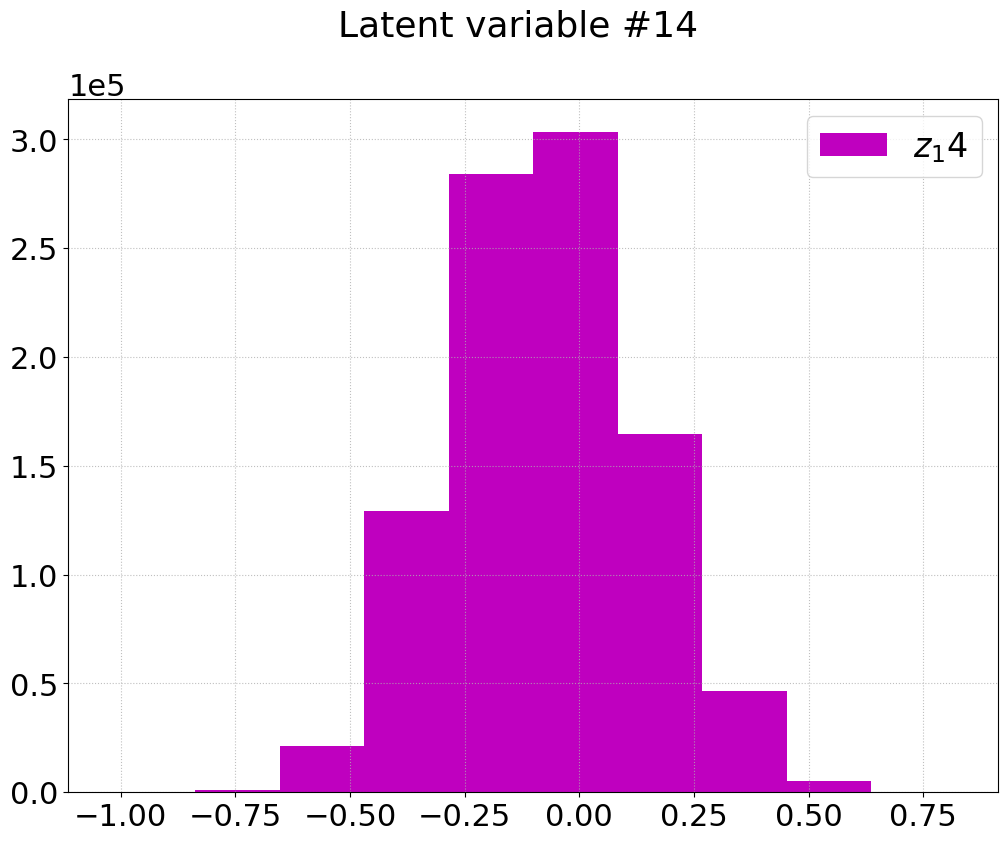

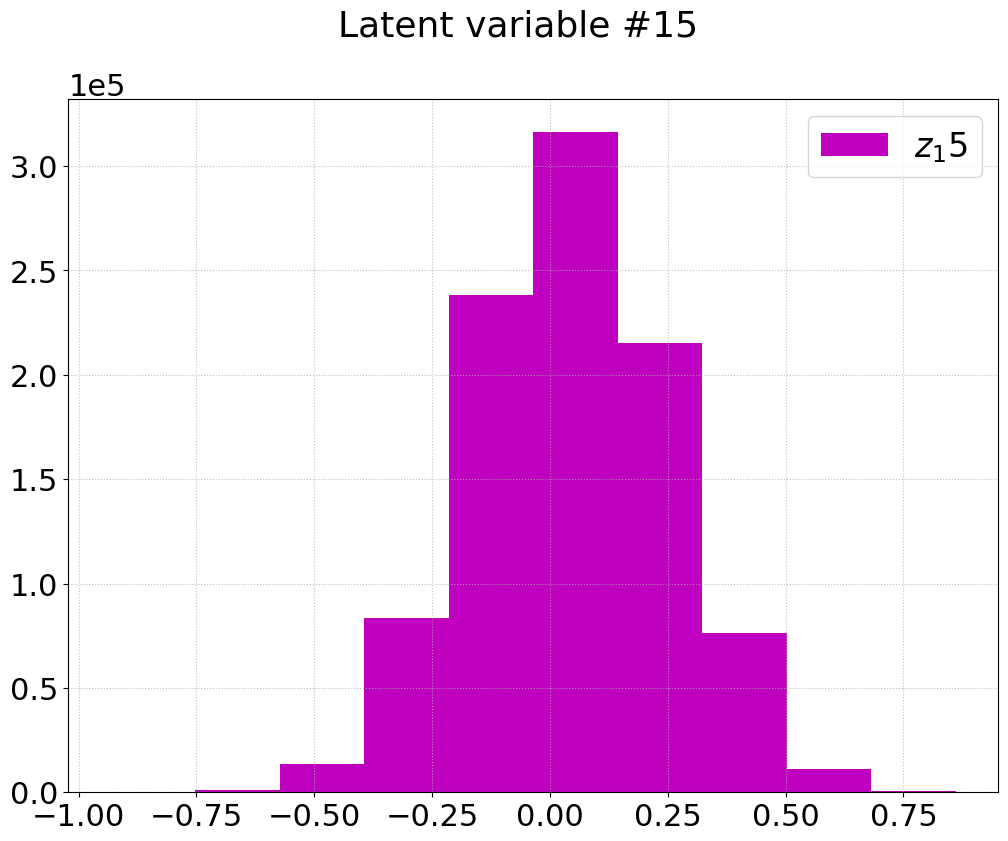

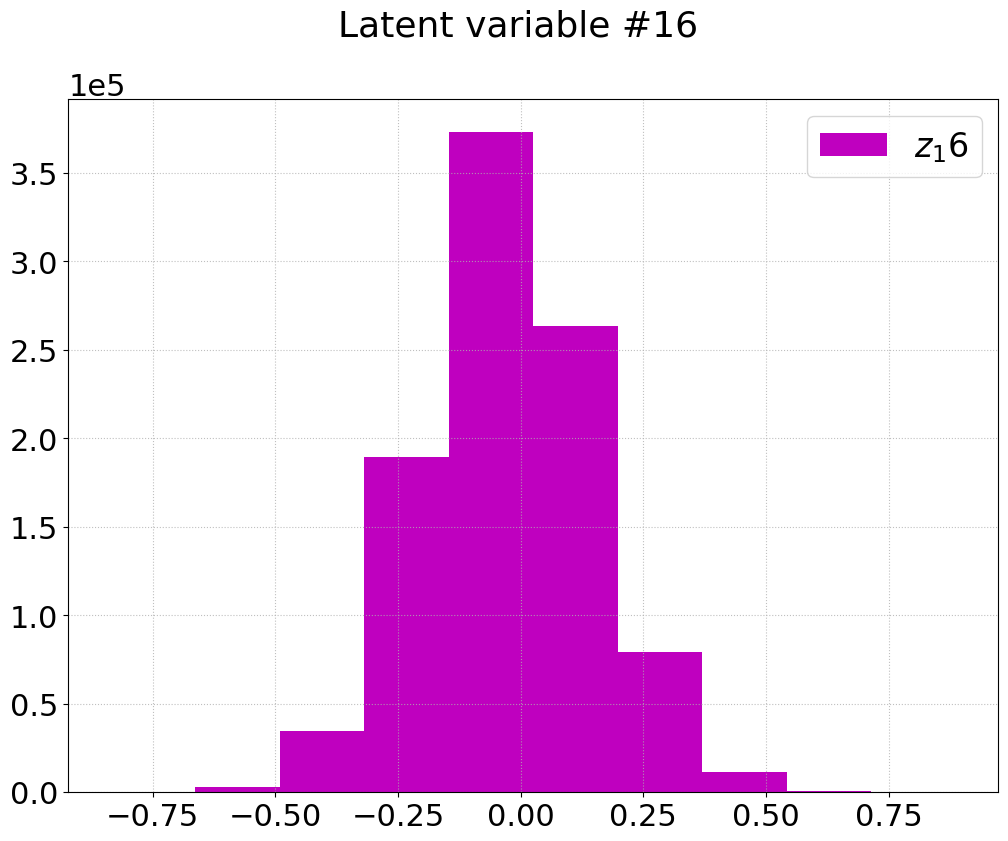

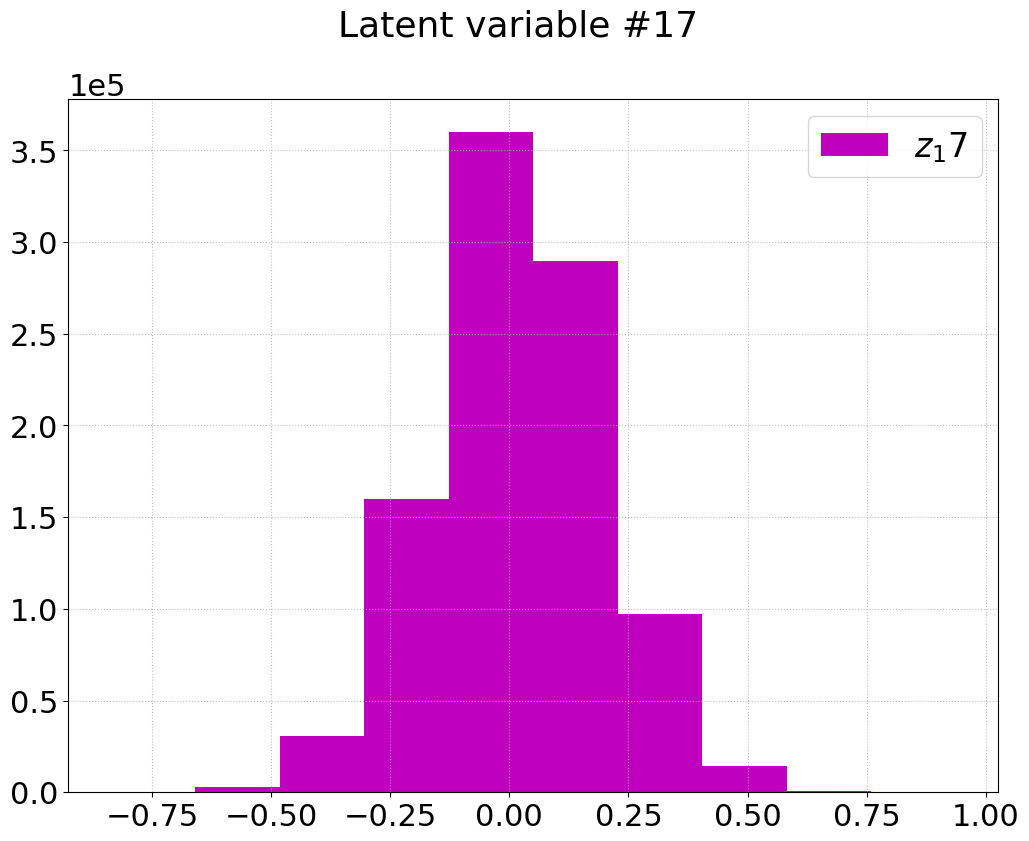

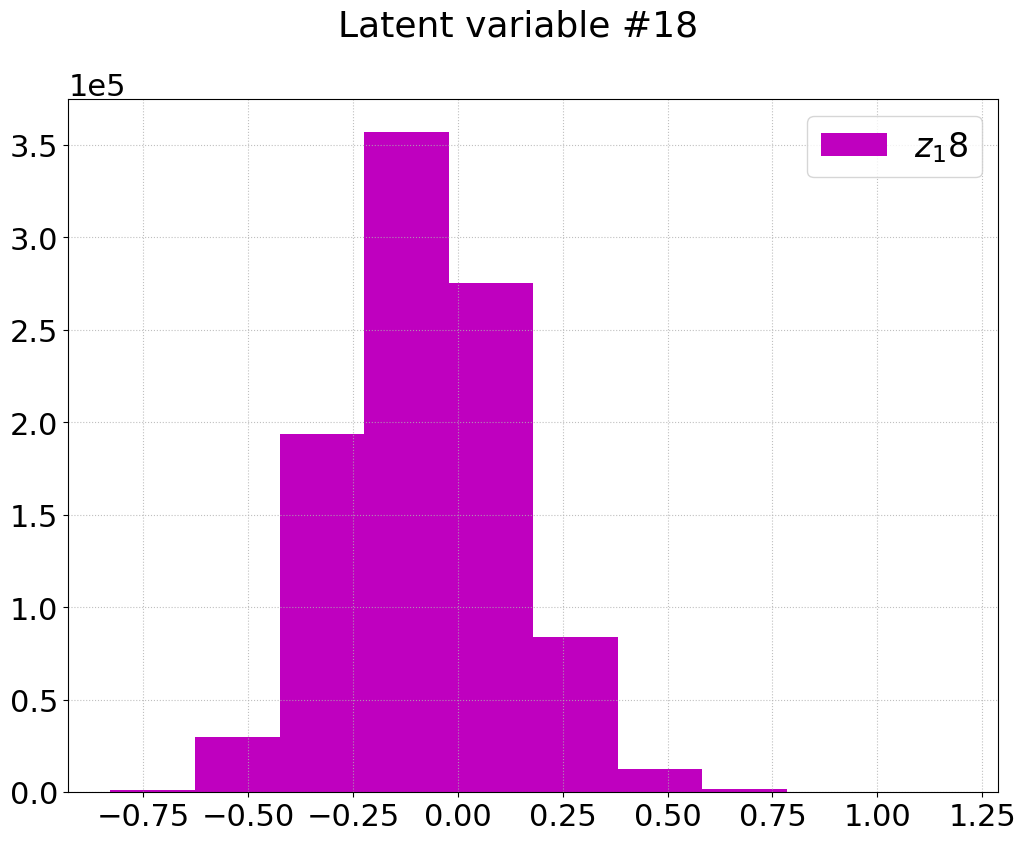

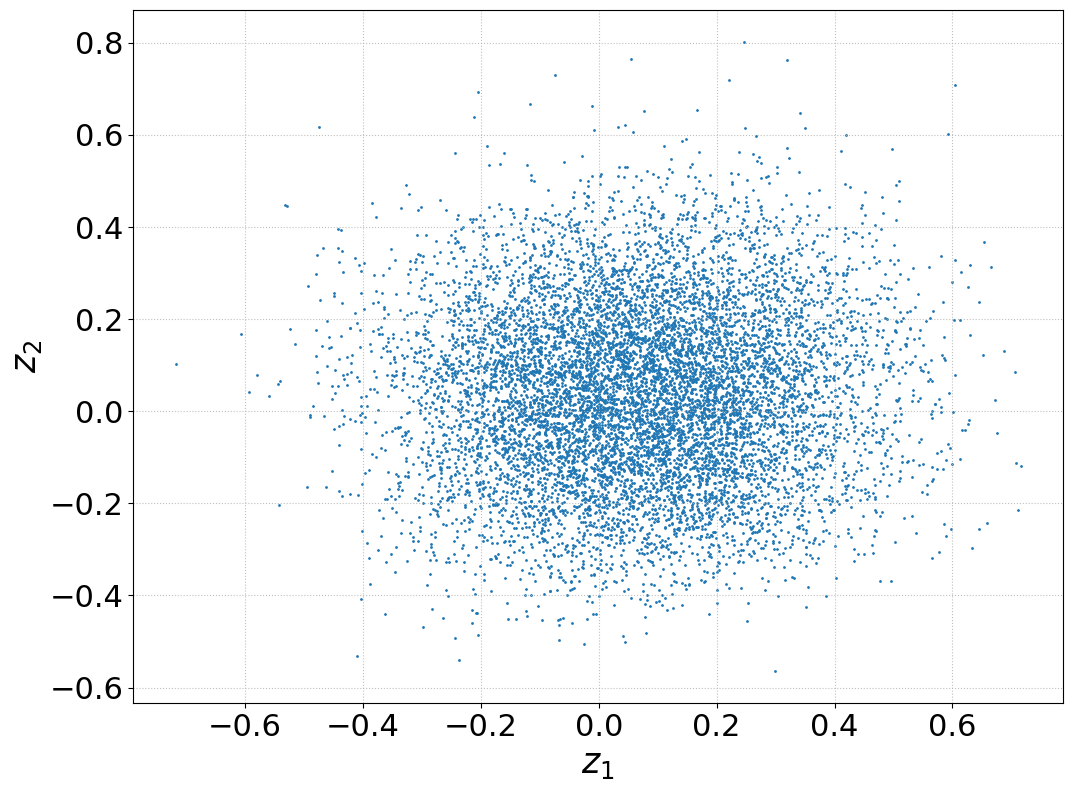

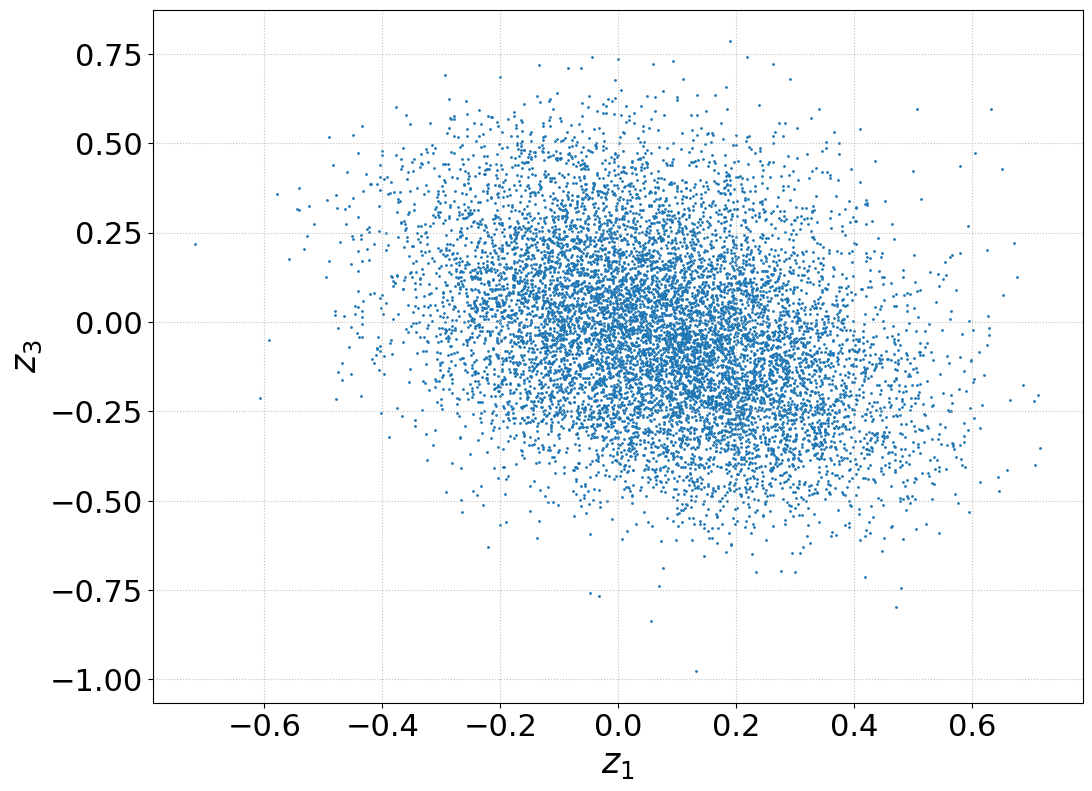

In [27]:
# Plot latent space
data = torch.tensor(train.values, dtype=torch.float)
latent = learn.model.encode(data).detach().numpy()
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()
    fig_name = 'latent_hist_z%d' % (ii + 1)

# Latent space scatter plots
idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(train[idxs[0]:idxs[1]].values, dtype=torch.float)
latent = learn.model.encode(data).detach().numpy()
mksz = 1
plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
fig_name = 'latent_scatter_z1z2'

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')
fig_name = 'latent_scatter_z1z3'
    

In [ ]:
batches = len(learn.recorder.losses)
epos = len(learn.recorder.val_losses)
val_iter = (batches / epos) * np.arange(1, epos + 1, 1)
loss_name = str(loss_func).split("(")[0]
plt.figure()
plt.plot(learn.recorder.losses, label='Train')
plt.plot(val_iter, learn.recorder.val_losses, label='Validation', color='orange')
plt.yscale(value='log')
plt.legend()
plt.ylabel(loss_name)
plt.xlabel('Batches processed')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
plt.yscale('log')

In [ ]:
learn.activation_stats.modules

In [ ]:
utils.plot_activations(learn)

In [ ]:
import pickle
with open('transforms_save_dict.pkl', 'rb') as f:
    tfsms = pickle.load(f)

In [ ]:
tfsms.keys()

In [ ]:
data = test[0:100000]
pred = model(torch.tensor(data.values, dtype=torch.float))

In [ ]:
unscaled_pred = tfsms['scaling_decode_transform'](pred)

In [ ]:
def plot_all(data, pred, logy=False, alph=0.8):
    for key in data.keys():
        plt.figure()
        n, bin_edges, _ = plt.hist(data[key], bins=80, color='c', label='Input', alpha=alph)
        plt.hist(pred[key], bins=bin_edges, color='orange', label='Output', alpha=alph)
        plt.legend()
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

In [ ]:
unscaled_pred_df = pd.DataFrame(unscaled_pred, columns=test.columns)

In [ ]:
pred_df = pd.DataFrame(pred.detach().numpy(), columns=test.columns)

In [ ]:
plot_all(data=data, pred=pred_df, logy=False)